# My project for Optimization Course

Multivariate linear regression implemented through solving an optimization problem using the gradient descent method and some of its variants.

The dataset used was taken from Kaggle.com and concerns house prices in the New York area. The idea is to perform a linear regression using the price as the dependent variable and the number of bedrooms, number of bathrooms, and the size of the house as independent variables.

In [ ]:

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("dataset/NY-House-Dataset.csv")
print(df.head())



1) Data Cleaning


In [ ]:
#ELIMINO LE COLONNE NON DESIDERATE

columns_to_drop = ["ADDRESS", "STATE", "MAIN_ADDRESS", "ADMINISTRATIVE_AREA_LEVEL_2", 
                   "LOCALITY", "STREET_NAME", "LONG_NAME", "FORMATTED_ADDRESS", 
                   "LATITUDE", "LONGITUDE","TYPE","SUBLOCALITY","BROKERTITLE"]
df_filtered = df.drop(columns=columns_to_drop)


#FILTRO GLI OUTLIER

vars = ["PRICE", "BEDS", "BATH", "PROPERTYSQFT"]
#df_filtered = df.copy()

# Filtra i valori anomali utilizzando il concetto di IQR
for var in vars:
    Q1 = df_filtered[var].quantile(0.25)
    Q3 = df_filtered[var].quantile(0.75)
    
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    df_filtered = df_filtered[(df_filtered[var] >= lower_limit) & (df_filtered[var] <= upper_limit)]
    
print(df_filtered.head)
    


Regression Model:

$y = w_0 + w_1 x1 + w_2 x2 + w_3 x3$

In this case:

$PRICE = w_0 + w_1 BEDS + w_2 BATH + w_3 PROPERTYSQFT$



In [ ]:
def standardize(x):
    """Standardize the original data points (mean 0 and std dev 1)."""
    x = x - np.mean(x)
    x = x / np.std(x)
    return x

def build_model_data(x, y):
    """Get regression data in matrix form."""
    b = y
    num_samples = len(b)
    A = np.c_[np.ones(num_samples), x]
    return A, b


In [ ]:

features = df_filtered[['BEDS', 'BATH', 'PROPERTYSQFT']]
prices = df_filtered['PRICE']
print(features)
print(prices)

A, b = build_model_data(standardize(features), standardize(prices))




In [ ]:
print('Number of samples n = ', b.shape[0])
print('Dimension of each sample d = ', A.shape[1])

1. Gradient descendent method functions

In [ ]:
def calculate_objective(Axmb):
    obj = (Axmb**2).sum()
    return obj

def compute_gradient(A, x, b):
    Axmb = A.dot(x) - b
    grad = 2 * A.T.dot(Axmb)
    return grad, Axmb

def gradient_descent(A, initial_x, b, max_iters,gamma):
    """Gradient descent algorithm."""
    # Define parameters to store x and objective func. values
    xs = [initial_x]
    objectives = []
    x = initial_x
    for n_iter in range(max_iters):
      
        # compute objective and gradient
        grad, Axmb = compute_gradient(A, x, b)
        obj = calculate_objective(Axmb)

        # ***************************************************
        # YOUR CODE HERE
        # update x by a gradient descent step
        x = x - gamma * grad
        # ***************************************************
        
        # store x and objective function value
        xs.append(x)
        objectives.append(obj)
        print("Gradient Descent({bi}/{ti}): objective={l:.5f}, x=[{w0:.5f},{w1:.5f},{w2:.5f},{w3:.5f}]".format(
              bi=n_iter, ti=max_iters - 1, l=obj, w0=x[0], w1=x[1], w2=x[2], w3=x[3]))

    return objectives, xs


test Classic Gradient descent 

In [ ]:

max_iters = 100
gamma = 0.0000001  # Tasso di apprendimento iniziale
x_initial = np.zeros(A.shape[1])


# Start gradient descent.
gradient_objectives_naive, gradient_xs_naive = gradient_descent(A, x_initial, b, max_iters, gamma)
print("########################")

plt.figure(figsize=(8, 8))
plt.xlabel('Number of steps')
plt.ylabel('Objective Function')
plt.plot(range(len(gradient_objectives_naive)), gradient_objectives_naive,'red', label='naive gradient descent')



We can try also to use a smoothness gradient descent with L parameter

In [ ]:
def calculate_L(A, b):
    """Calculate the smoothness constant for f"""
    # ***************************************************
    # YOUR CODE HERE
    # compute L = smoothness constant of f
    L = 2 * np.linalg.norm(A.T.dot(A), ord=2)
    # ***************************************************
    return L

In [ ]:

max_iters = 20
gamma_smooth = 1/calculate_L(A,b)
print(gamma_smooth)
x_initial = np.zeros(A.shape[1])

# Start gradient descent.
gradient_objectives_smooth, gradient_xs_smooth = gradient_descent(A, x_initial, b, max_iters, gamma_smooth)

plt.figure(figsize=(8, 8))
plt.xlabel('Number of steps')
plt.ylabel('Objective Function')
plt.plot(range(len(gradient_objectives_smooth)), gradient_objectives_smooth,'green', label='gradient descent assuming smoothness')

LIPSCHITZ

Gradient Descent(0/49): objective=3659.00000, x=[-0.00000,0.00000,0.00000,0.00000]
Gradient Descent(1/49): objective=3658.99951, x=[0.00000,0.00000,0.00000,0.00000]
Gradient Descent(2/49): objective=3658.99912, x=[0.00000,0.00000,0.00000,0.00000]
Gradient Descent(3/49): objective=3658.99881, x=[0.00000,0.00000,0.00000,0.00000]
Gradient Descent(4/49): objective=3658.99855, x=[0.00000,0.00000,0.00000,0.00000]
Gradient Descent(5/49): objective=3658.99833, x=[0.00000,0.00000,0.00000,0.00000]
Gradient Descent(6/49): objective=3658.99814, x=[0.00000,0.00000,0.00000,0.00000]
Gradient Descent(7/49): objective=3658.99797, x=[0.00000,0.00000,0.00000,0.00000]
Gradient Descent(8/49): objective=3658.99782, x=[0.00000,0.00000,0.00000,0.00000]
Gradient Descent(9/49): objective=3658.99768, x=[0.00000,0.00000,0.00000,0.00000]
Gradient Descent(10/49): objective=3658.99755, x=[0.00000,0.00000,0.00000,0.00000]
Gradient Descent(11/49): objective=3658.99743, x=[0.00000,0.00000,0.00000,0.00000]
Gradient Desc

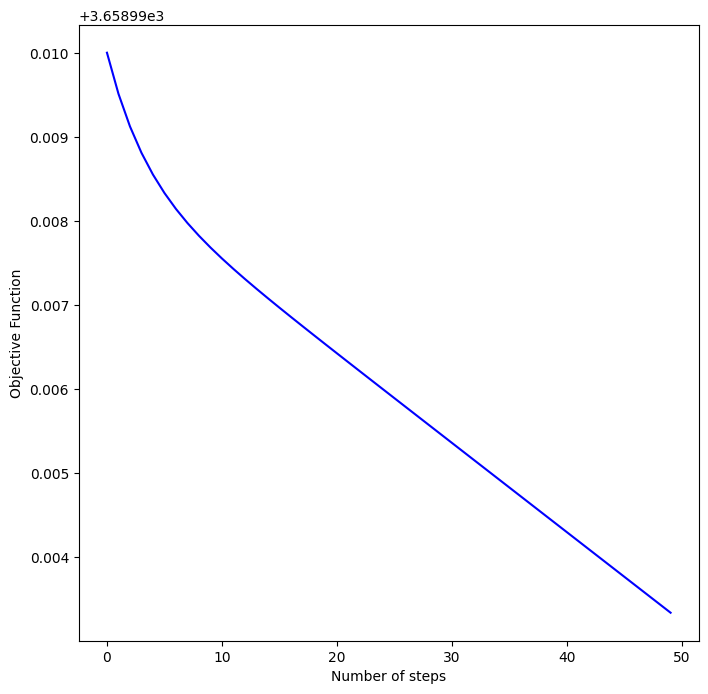

In [48]:
max_iters = 50
R = 25

# ***************************************************
# YOUR CODE HERE
# Compute the bound B on the gradient norm
B = 2 * (R*np.linalg.norm(np.dot(A.T,A)) + np.linalg.norm(np.dot(A.T,b)))
# ***************************************************

# ***************************************************
# YOUR CODE HERE
#  Compute learning rate based on bounded gradient
gamma_bounded = R/(B*np.sqrt(max_iters))
# ***************************************************

# Start gradient descent.
gradient_objectives_bounded, gradient_xs_bounded = gradient_descent(A, x_initial, b, max_iters, gamma_bounded)
plt.figure(figsize=(8, 8))
plt.xlabel('Number of steps')
plt.ylabel('Objective Function')
plt.plot(range(len(gradient_objectives_bounded)), gradient_objectives_bounded,'blue', label='gradient descent assuming bounded gradients')

STOCHASTIC GRADIENT


In [ ]:
def full_objective(A, x, b):
    """Compute the least squares objective over the whole dataset"""
    return np.mean((A.dot(x) - b)**2)

x_star = np.linalg.solve(A.T.dot(A), A.T.dot(b)) #solve Ax = b
best_objective = full_objective(A, x_star, b)
print("f(x*) = ", best_objective)

In [ ]:
def minibatch_gradient(A, x, b):
    """
    Compute a mini-batch stochastic gradient from a subset of `num_examples` from the dataset.
    
    :param b: a numpy array of shape (num_examples)
    :param A: a numpy array of shape (num_examples, num_features)
    :param x: compute the mini-batch gradient at these parameters, numpy array of shape (num_features)
    
    :return: gradient: numpy array of shape (num_features)
    """
    # ***************************************************
    # YOUR CODE HERE
    # TODO: implement gradient computation.
    # ***************************************************
    batch_size = len(b)
    Axmb = A.dot(x) - b
    gradient = A.T.dot(Axmb) / batch_size
    return gradient

In [ ]:
num_trials = 10
for i in range(num_trials):
    # Try different parameter vectors $x$
    x = np.random.rand(A.shape[1])

    stochastic_gradients = []
    # *********************************************************
    # YOUR CODE HERE
    # TODO: Compute all stochastic gradients, mini-batch size 1
    # *********************************************************
    for i in range(len(b)):
        stochastic_gradients.append(minibatch_gradient(A[i:i+1, :], x, b[i:i+1]))

    # axis = 0 is the mean along the column
    mean_stochastic_gradients = np.mean(stochastic_gradients, axis = 0)

    # *********************************************************
    # YOUR CODE HERE
    # *********************************************************
    full_gradient = minibatch_gradient(A, x, b)

    # Those should be the same on average
    assert np.allclose(mean_stochastic_gradients, full_gradient)
    
print('Tests passed')

In [ ]:
def stochastic_gradient(A, x, b, batch_size=1):
    """Compute a stochastic gradient"""
    dataset_size = len(b)
    indices = np.random.choice(dataset_size, batch_size, replace=False)
    return minibatch_gradient(A[indices, :], x, b[indices])

def stochastic_gradient_descent(
        data_A, 
        initial_x, 
        targets_b, 
        batch_size, 
        max_iters, 
        learning_rate):
    """
    Mini-batch Stochastic Gradient Descent for Linear Least Squares problems.
    
    :param data_A: numpy array of size (num_examples, num_features)
    :param initial_x: starting parameters, a numpy array of size (num_features)
    :param targets_b: numpy array of size (num_examples)
    :param batch_size: size of the mini-batches
    :param max_iters: integer, number of updates to do
    :param learning_rate: float
    :param decreasing_learning_rate: if true, the learning rate should decay as 1 / t 
    
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - xs, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    xs = [initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    
    # ***************************************************
    # YOUR CODE HERE
    # TODO: implement stochastic gradient descent.
    # ***************************************************
    for iteration in range(max_iters):
        grad = stochastic_gradient(data_A, x, targets_b, batch_size=batch_size)

        # update x through the stochastic gradient update
        x = x - learning_rate * grad

        # store x and objective
        xs.append(x.copy())
        objective = full_objective(data_A, x, targets_b)
        objectives.append(objective)
        
        if iteration % 1000 == 0:
            print("SGD({bi:04d}/{ti:04d}): objective = {l:10.2f}".format(
                  bi=iteration, ti=max_iters - 1, l=objective))

    return objectives, xs

In [ ]:
import datetime

# Define the parameters of the algorithm.
max_iters = int(1e4)
gamma = 0.2   # this is totally arbitrary
batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives, sgd_xs = stochastic_gradient_descent(A, x_initial, b, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

In [ ]:
plt.title('Convergence rates', fontsize = 20)
plt.loglog(sgd_objectives - best_objective, label = r'$\gamma = 0.2$')
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()